# Setup

In [1]:
import os
import glob
import json
import re

import pandas as pd

import matplotlib.pyplot as plt

from w3lib.html import remove_tags
# Notebook settings
import warnings
warnings.filterwarnings('ignore')

# New York Times Dataset

In [110]:
# Load one file
nyt_2021_10_df = pd.read_csv('../data/raw/nyt_headlines/nyt_2021-10.csv')
nyt_2021_10_df.head()

,headline,date,doc_type,material_type,section,keywords,word_count,abstract,snippet,lead_paragraph
0,When the Doctor’s Notes Hurt Your Feelings,2021-10-01,article,News,Well,"['Electronic Health Records', 'Doctors', 'inte...",1203,"Are you a “poor historian,” “well nourished” o...","Are you a “poor historian,” “well nourished” o...",Have you ever been insulted by your own medica...
1,House Delays Vote on Infrastructure Bill as De...,2021-10-01,article,News,U.S.,"['Infrastructure (Public Works)', 'American Jo...",1561,A liberal revolt left Democrats short of votes...,A liberal revolt left Democrats short of votes...,WASHINGTON — President Biden’s trillion-dollar...
2,Tirzah’s Genre-Less Pop Embraces the Beauty of...,2021-10-01,article,Review,Arts,['Music'],546,"The British singer-songwriter’s new album, “Co...","The British singer-songwriter’s new album, “Co...","Some pop artists amplify familiar, universal f..."
3,Senate Confirms Biden’s Pick to Lead the Burea...,2021-10-01,article,News,Climate,"['Global Warming', 'Greenhouse Gas Emissions',...",641,"After a party-line vote, Tracy Stone-Manning b...","After a party-line vote, Tracy Stone-Manning b...",WASHINGTON — The Senate narrowly approved Trac...
4,UMass Amherst Hires Cybersecurity Firm to Inve...,2021-10-01,article,News,Education,"['Colleges and Universities', 'Discrimination'...",688,The university’s vice chancellor told students...,The university’s vice chancellor told students...,The University of Massachusetts Amherst has en...


In [111]:
nyt_2021_10_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4254 entries, 0 to 4253
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   headline        4254 non-null   object
 1   date            4254 non-null   object
 2   doc_type        4254 non-null   object
 3   material_type   4250 non-null   object
 4   section         4254 non-null   object
 5   keywords        4254 non-null   object
 6   word_count      4254 non-null   int64 
 7   abstract        4253 non-null   object
 8   snippet         4208 non-null   object
 9   lead_paragraph  4236 non-null   object
dtypes: int64(1), object(9)
memory usage: 332.5+ KB


In [68]:
print(nyt_2021_10_df['doc_type'].describe())
print(nyt_2021_10_df['doc_type'].unique())
print(nyt_2021_10_df['doc_type'].value_counts())

count        4254
unique          3
top       article
freq         3978
Name: doc_type, dtype: object
['article' 'multimedia' 'audio']
article       3978
multimedia     272
audio            4
Name: doc_type, dtype: int64


`doc_type`: There are three types of documents in the data. We're only interested in articles.

In [112]:
nyt_articles = nyt_2021_10_df[nyt_2021_10_df['doc_type'] == 'article']

In [113]:
print(nyt_articles['material_type'].describe())
print(nyt_articles['material_type'].unique())
print(nyt_articles['material_type'].value_counts())

count     3978
unique      12
top       News
freq      3122
Name: material_type, dtype: object
['News' 'Review' 'briefing' 'Op-Ed' 'List' 'Letter' 'Obituary (Obit)'
 'Correction' 'Editorial' 'Quote' 'News Analysis' 'Biography']
News               3122
Op-Ed               301
Review              210
briefing            130
Obituary (Obit)      94
Letter               53
Quote                24
Correction           20
List                 10
News Analysis         7
Editorial             6
Biography             1
Name: material_type, dtype: int64


Most articles belong to `matrial_type` *News*, the other categories can probably be discarded for our purposes.

In [130]:
nyt_news_articles = nyt_articles[nyt_articles['material_type'] == 'News']

In [132]:
print(nyt_news_articles['section'].describe())
print(nyt_news_articles['section'].unique())
print(nyt_news_articles['section'].value_counts())

count     3122
unique      39
top       U.S.
freq       506
Name: section, dtype: object
['Well' 'U.S.' 'Climate' 'Education' 'Business Day' 'Science' 'Technology'
 'World' 'Crosswords & Games' 'Style' 'The Learning Network' 'Arts'
 'Today’s Paper' 'Corrections' 'Reader Center' 'New York' 'The Upshot'
 'Fashion & Style' 'Real Estate' 'Sports' 'Podcasts' 'Theater'
 'Your Money' 'T Magazine' 'Movies' 'Food' 'Books' 'At Home' 'Health'
 'Times Insider' 'Travel' 'Briefing' 'Magazine' 'Parenting'
 'Neediest Cases' 'Opinion' 'Automobiles' 'Special Series' 'Home & Garden']
U.S.                    506
World                   444
Business Day            315
Sports                  274
Arts                    254
Style                   153
New York                152
The Learning Network    108
Technology               92
Books                    92
Food                     74
Crosswords & Games       72
Science                  65
Real Estate              64
Health                   63
Movies  

In [133]:
nyt_news_articles = nyt_news_articles.drop(['doc_type', 'material_type'], axis=1)

In [134]:
nyt_news_articles.head()

,headline,date,section,keywords,word_count,abstract,snippet,lead_paragraph
0,When the Doctor’s Notes Hurt Your Feelings,2021-10-01,Well,"['Electronic Health Records', 'Doctors', 'inte...",1203,"Are you a “poor historian,” “well nourished” o...","Are you a “poor historian,” “well nourished” o...",Have you ever been insulted by your own medica...
1,House Delays Vote on Infrastructure Bill as De...,2021-10-01,U.S.,"['Infrastructure (Public Works)', 'American Jo...",1561,A liberal revolt left Democrats short of votes...,A liberal revolt left Democrats short of votes...,WASHINGTON — President Biden’s trillion-dollar...
3,Senate Confirms Biden’s Pick to Lead the Burea...,2021-10-01,Climate,"['Global Warming', 'Greenhouse Gas Emissions',...",641,"After a party-line vote, Tracy Stone-Manning b...","After a party-line vote, Tracy Stone-Manning b...",WASHINGTON — The Senate narrowly approved Trac...
4,UMass Amherst Hires Cybersecurity Firm to Inve...,2021-10-01,Education,"['Colleges and Universities', 'Discrimination'...",688,The university’s vice chancellor told students...,The university’s vice chancellor told students...,The University of Massachusetts Amherst has en...
5,‘Everything Going the Wrong Way’: Dollar Store...,2021-10-01,Business Day,"['Shopping and Retail', 'Wages and Salaries', ...",1596,Their business model is being tested by worker...,Their business model is being tested by worker...,Sandra Beadling was fed up with the 70-hour wo...


Text columns:

- `headline`: title of th article   
- `abstract`: summary of the article  
- `snippet`: excerpt of the article, looks to be the same as abstract  
- `lead_paragraph`: first paragraph of the article

In [135]:
# Difference between abstract and snippet
nyt_news_articles['abstract_eq_snippet'] = nyt_news_articles.apply(lambda x: x['abstract'] == x['snippet'], axis=1)

In [136]:
nyt_news_articles['abstract_eq_snippet'].describe()

count     3122
unique       2
top       True
freq      3075
Name: abstract_eq_snippet, dtype: object

In [137]:
nyt_news_articles[nyt_news_articles['abstract_eq_snippet'] == False].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 70 to 4184
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   headline             47 non-null     object
 1   date                 47 non-null     object
 2   section              47 non-null     object
 3   keywords             47 non-null     object
 4   word_count           47 non-null     int64 
 5   abstract             47 non-null     object
 6   snippet              2 non-null      object
 7   lead_paragraph       47 non-null     object
 8   abstract_eq_snippet  47 non-null     bool  
dtypes: bool(1), int64(1), object(7)
memory usage: 3.4+ KB


There are 47 cases where abstract and snippet are different.

In [138]:
nyt_news_articles.head()

,headline,date,section,keywords,word_count,abstract,snippet,lead_paragraph,abstract_eq_snippet
0,When the Doctor’s Notes Hurt Your Feelings,2021-10-01,Well,"['Electronic Health Records', 'Doctors', 'inte...",1203,"Are you a “poor historian,” “well nourished” o...","Are you a “poor historian,” “well nourished” o...",Have you ever been insulted by your own medica...,True
1,House Delays Vote on Infrastructure Bill as De...,2021-10-01,U.S.,"['Infrastructure (Public Works)', 'American Jo...",1561,A liberal revolt left Democrats short of votes...,A liberal revolt left Democrats short of votes...,WASHINGTON — President Biden’s trillion-dollar...,True
3,Senate Confirms Biden’s Pick to Lead the Burea...,2021-10-01,Climate,"['Global Warming', 'Greenhouse Gas Emissions',...",641,"After a party-line vote, Tracy Stone-Manning b...","After a party-line vote, Tracy Stone-Manning b...",WASHINGTON — The Senate narrowly approved Trac...,True
4,UMass Amherst Hires Cybersecurity Firm to Inve...,2021-10-01,Education,"['Colleges and Universities', 'Discrimination'...",688,The university’s vice chancellor told students...,The university’s vice chancellor told students...,The University of Massachusetts Amherst has en...,True
5,‘Everything Going the Wrong Way’: Dollar Store...,2021-10-01,Business Day,"['Shopping and Retail', 'Wages and Salaries', ...",1596,Their business model is being tested by worker...,Their business model is being tested by worker...,Sandra Beadling was fed up with the 70-hour wo...,True


In [139]:
nyt_news_articles[nyt_news_articles['abstract_eq_snippet'] == False].head()

,headline,date,section,keywords,word_count,abstract,snippet,lead_paragraph,abstract_eq_snippet
70,Covid cases hit records in South Korea and Sin...,2021-10-01,World,[],440,As countries in Asia accelerate their vaccinat...,NaN,As countries in Asia accelerate their vaccinat...,False
385,Vaccination rates rise among teachers and othe...,2021-10-04,New York,[],406,New York’s requirement that virtually everyone...,NaN,New York’s requirement that virtually everyone...,False
389,New Zealand abandons its goal of eliminating t...,2021-10-04,World,[],607,Prime Minister Jacinda Ardern of New Zealand a...,NaN,Prime Minister Jacinda Ardern of New Zealand a...,False
394,Supply-chain snarls reach the book publishing ...,2021-10-04,World,[],269,The churning disruption in the global supply c...,NaN,The churning disruption in the global supply c...,False
550,Fears of a ‘bottleneck recession’: How shortag...,2021-10-05,World,[],195,"In Germany, where one in four jobs depends on ...",NaN,"In Germany, where one in four jobs depends on ...",False


When abstract and snippet are different, in most cases it is due to missing values in snippet column.

In [140]:
# Drop snippet and abstract_eq_snippet columns
nyt_news_articles.drop(['snippet', 'abstract_eq_snippet'], axis=1, inplace=True)

In [141]:
nyt_news_articles.head()

,headline,date,section,keywords,word_count,abstract,lead_paragraph
0,When the Doctor’s Notes Hurt Your Feelings,2021-10-01,Well,"['Electronic Health Records', 'Doctors', 'inte...",1203,"Are you a “poor historian,” “well nourished” o...",Have you ever been insulted by your own medica...
1,House Delays Vote on Infrastructure Bill as De...,2021-10-01,U.S.,"['Infrastructure (Public Works)', 'American Jo...",1561,A liberal revolt left Democrats short of votes...,WASHINGTON — President Biden’s trillion-dollar...
3,Senate Confirms Biden’s Pick to Lead the Burea...,2021-10-01,Climate,"['Global Warming', 'Greenhouse Gas Emissions',...",641,"After a party-line vote, Tracy Stone-Manning b...",WASHINGTON — The Senate narrowly approved Trac...
4,UMass Amherst Hires Cybersecurity Firm to Inve...,2021-10-01,Education,"['Colleges and Universities', 'Discrimination'...",688,The university’s vice chancellor told students...,The University of Massachusetts Amherst has en...
5,‘Everything Going the Wrong Way’: Dollar Store...,2021-10-01,Business Day,"['Shopping and Retail', 'Wages and Salaries', ...",1596,Their business model is being tested by worker...,Sandra Beadling was fed up with the 70-hour wo...


In [148]:
for i in range(3):
    print(nyt_news_articles.iloc[i]['headline'])
    print(nyt_news_articles.iloc[i]['abstract'])
    print(nyt_news_articles.iloc[i]['lead_paragraph'])
    print('\n')

When the Doctor’s Notes Hurt Your Feelings
Are you a “poor historian,” “well nourished” or in need of a “time out”? As patients gain access to their own medical records, the notes left by doctors can sting.
Have you ever been insulted by your own medical records?


House Delays Vote on Infrastructure Bill as Democrats Feud
A liberal revolt left Democrats short of votes, but leaders insisted they would bring up the measure again on Friday, giving them more time to reach a deal on a separate climate and safety net bill.
WASHINGTON — President Biden’s trillion-dollar bipartisan infrastructure plan suffered a significant setback late Thursday night when House Democratic leaders, short of support amid a liberal revolt, put off a planned vote on a crucial plank of their domestic agenda.


Senate Confirms Biden’s Pick to Lead the Bureau of Land Management
After a party-line vote, Tracy Stone-Manning became the leader of an agency that manages oil and gas drilling on public lands.
WASHINGTON —

The lead_paragraph is really only an intro to the full text, the abstract seems to be the better summary.

In [149]:
nyt_news_articles = nyt_news_articles.drop(['lead_paragraph'], axis=1)

In [150]:
nyt_news_articles['word_count'].describe()

count     3122.000000
mean       986.676169
std        658.024050
min          0.000000
25%        563.250000
50%        940.000000
75%       1284.000000
max      10220.000000
Name: word_count, dtype: float64

In [151]:
nyt_news_articles[nyt_news_articles['word_count'] == 0]

,headline,date,section,keywords,word_count,abstract
1547,The Return of the Monogrammed Carryall,2021-10-12,T Magazine,"['Leather and Leather Goods', 'Fashion and App...",0,"This season, the most sought-after briefcases,..."


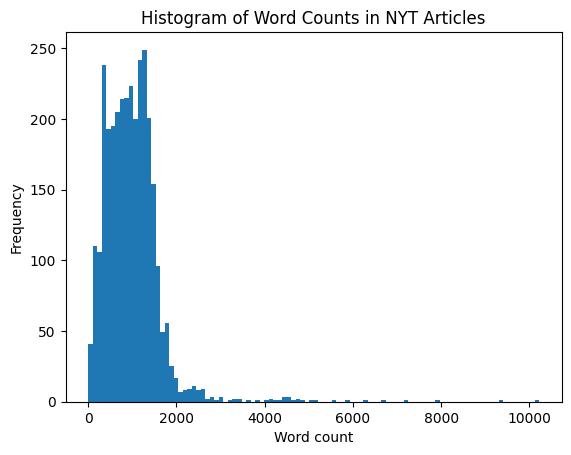

In [144]:
plt.hist(nyt_news_articles['word_count'], bins=100)
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in NYT Articles')
plt.show()

In [168]:
nyt_news_articles.reset_index(drop=True, inplace=True)

In [170]:
nyt_news_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   headline    3122 non-null   object
 1   date        3122 non-null   object
 2   section     3122 non-null   object
 3   keywords    3122 non-null   object
 4   word_count  3122 non-null   int64 
 5   abstract    3122 non-null   object
dtypes: int64(1), object(5)
memory usage: 146.5+ KB


In [152]:
nyt_news_articles.columns

Index(['headline', 'date', 'section', 'keywords', 'word_count', 'abstract'], dtype='object')

In [153]:
nyt_2021_10_df.columns

Index(['headline', 'date', 'doc_type', 'material_type', 'section', 'keywords',
       'word_count', 'abstract', 'snippet', 'lead_paragraph'],
      dtype='object')

# Guardian Dataset

In [2]:
# Load Guardian data
files_gu = glob.glob('../data/raw/guardian/*.json')

In [3]:
files_gu

['../data/raw/guardian/ga_2022-03-27_2022-04-26.json',
 '../data/raw/guardian/ga_2021-09-27_2021-10-26.json',
 '../data/raw/guardian/ga_2022-05-27_2022-06-26.json',
 '../data/raw/guardian/ga_2022-06-27_2022-07-26.json',
 '../data/raw/guardian/ga_2021-11-27_2021-12-26.json',
 '../data/raw/guardian/ga_2022-07-27_2022-08-26.json',
 '../data/raw/guardian/ga_2022-02-27_2022-03-26.json',
 '../data/raw/guardian/ga_2022-01-27_2022-02-26.json',
 '../data/raw/guardian/ga_2022-08-27_2022-09-27.json',
 '../data/raw/guardian/ga_2021-10-27_2021-11-26.json',
 '../data/raw/guardian/ga_2021-12-27_2022-01-26.json',
 '../data/raw/guardian/ga_2022-04-27_2022-05-26.json']

In [4]:
f = open('../data/raw/guardian/ga_2022-03-27_2022-04-26.json')
gu_data = json.load(f)
f.close()

In [5]:
len(gu_data)

6586

In [6]:
gu_data[0]

{'id': 'seek-the-new-world-of-work-/2022/apr/27/why-2022-is-the-year-of-the-great-job-boom-and-what-you-need-to-know-about-it',
 'type': 'article',
 'sectionId': 'seek-the-new-world-of-work-',
 'sectionName': 'Seek: The new world of work',
 'webPublicationDate': '2022-04-26T23:39:50Z',
 'webTitle': 'Why 2022 is the year of the ‘great job boom’ and what you need to know about it',
 'webUrl': 'https://www.theguardian.com/seek-the-new-world-of-work-/2022/apr/27/why-2022-is-the-year-of-the-great-job-boom-and-what-you-need-to-know-about-it',
 'apiUrl': 'https://content.guardianapis.com/seek-the-new-world-of-work-/2022/apr/27/why-2022-is-the-year-of-the-great-job-boom-and-what-you-need-to-know-about-it',
 'fields': {'headline': 'Why 2022 is the year of the ‘great job boom’ and what you need to know about it',
  'standfirst': '<p>The pandemic has changed global workforces. In Australia, it has put the power in the hands of jobseekers.</p>',
  'trailText': 'The pandemic has changed global work

In [7]:
pd.json_normalize(gu_data[0])

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,tags,isHosted,...,fields.showInRelatedContent,fields.thumbnail,fields.legallySensitive,fields.lang,fields.isLive,fields.bodyText,fields.charCount,fields.shouldHideReaderRevenue,fields.showAffiliateLinks,fields.bylineHtml
0,seek-the-new-world-of-work-/2022/apr/27/why-20...,article,seek-the-new-world-of-work-,Seek: The new world of work,2022-04-26T23:39:50Z,Why 2022 is the year of the ‘great job boom’ a...,https://www.theguardian.com/seek-the-new-world...,https://content.guardianapis.com/seek-the-new-...,[{'id': 'seek-the-new-world-of-work-/seek-the-...,False,...,true,https://media.guim.co.uk/9f6b26af0a4ab397a2ce8...,false,en,true,Australia’s job market is in the middle of a m...,4782,false,false,


In [8]:
pd.json_normalize(gu_data[0]).columns

Index(['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate',
       'webTitle', 'webUrl', 'apiUrl', 'tags', 'isHosted', 'fields.headline',
       'fields.standfirst', 'fields.trailText', 'fields.byline', 'fields.main',
       'fields.body', 'fields.wordcount', 'fields.displayHint',
       'fields.firstPublicationDate', 'fields.isInappropriateForSponsorship',
       'fields.isPremoderated', 'fields.lastModified',
       'fields.productionOffice', 'fields.publication', 'fields.shortUrl',
       'fields.shouldHideAdverts', 'fields.showInRelatedContent',
       'fields.thumbnail', 'fields.legallySensitive', 'fields.lang',
       'fields.isLive', 'fields.bodyText', 'fields.charCount',
       'fields.shouldHideReaderRevenue', 'fields.showAffiliateLinks',
       'fields.bylineHtml'],
      dtype='object')

## TODO

- [x] flatten columns with json_normalize
- [x] rename columns that start with field.
- [ ] get list of tags for each article
- [ ] drop useless columns

### Flatten nested columns

In [9]:
# turn json into dataframe with nested structures flattened
gu_df = pd.json_normalize(gu_data)
gu_df.head()

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,tags,isHosted,...,pillarId,pillarName,fields.newspaperPageNumber,fields.newspaperEditionDate,fields.commentCloseDate,fields.commentable,fields.starRating,fields.liveBloggingNow,fields.sensitive,fields.scheduledPublicationDate
0,seek-the-new-world-of-work-/2022/apr/27/why-20...,article,seek-the-new-world-of-work-,Seek: The new world of work,2022-04-26T23:39:50Z,Why 2022 is the year of the ‘great job boom’ a...,https://www.theguardian.com/seek-the-new-world...,https://content.guardianapis.com/seek-the-new-...,[{'id': 'seek-the-new-world-of-work-/seek-the-...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,world/2022/apr/26/us-covid-infections-antibodi...,article,world,World news,2022-04-26T23:28:51Z,"More than half of Americans have had Covid, in...",https://www.theguardian.com/world/2022/apr/26/...,https://content.guardianapis.com/world/2022/ap...,"[{'id': 'world/coronavirus-outbreak', 'type': ...",False,...,pillar/news,News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,media/2022/apr/27/mail-on-sunday-editor-reject...,article,media,Media,2022-04-26T23:16:08Z,Mail on Sunday editor rejects meeting with Spe...,https://www.theguardian.com/media/2022/apr/27/...,https://content.guardianapis.com/media/2022/ap...,"[{'id': 'media/mailonsunday', 'type': 'keyword...",False,...,pillar/news,News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,technology/2022/apr/26/alphabet-google-revenue...,article,technology,Technology,2022-04-26T23:05:49Z,Alphabet revenue falls short as YouTube and Ti...,https://www.theguardian.com/technology/2022/ap...,https://content.guardianapis.com/technology/20...,"[{'id': 'technology/alphabet', 'type': 'keywor...",False,...,pillar/news,News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,education/2022/apr/27/student-loan-change-engl...,article,education,Education,2022-04-26T23:01:11Z,IFS: England’s student loan change to hit poor...,https://www.theguardian.com/education/2022/apr...,https://content.guardianapis.com/education/202...,"[{'id': 'education/students', 'type': 'keyword...",False,...,pillar/news,News,24,2022-04-27T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
gu_df.columns

Index(['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate',
       'webTitle', 'webUrl', 'apiUrl', 'tags', 'isHosted', 'fields.headline',
       'fields.standfirst', 'fields.trailText', 'fields.byline', 'fields.main',
       'fields.body', 'fields.wordcount', 'fields.displayHint',
       'fields.firstPublicationDate', 'fields.isInappropriateForSponsorship',
       'fields.isPremoderated', 'fields.lastModified',
       'fields.productionOffice', 'fields.publication', 'fields.shortUrl',
       'fields.shouldHideAdverts', 'fields.showInRelatedContent',
       'fields.thumbnail', 'fields.legallySensitive', 'fields.lang',
       'fields.isLive', 'fields.bodyText', 'fields.charCount',
       'fields.shouldHideReaderRevenue', 'fields.showAffiliateLinks',
       'fields.bylineHtml', 'pillarId', 'pillarName',
       'fields.newspaperPageNumber', 'fields.newspaperEditionDate',
       'fields.commentCloseDate', 'fields.commentable', 'fields.starRating',
       'fields.liveBloggingNow',

Columns originally nested inside `fields` have the name prefix `fields.`.

### Rename columns starting with 'fields.'

In [12]:
# create dictionary to rename columns with prefix
colnames = {}

for colname in gu_df.columns:
    if colname.startswith('fields.'):
        colnames[colname] = re.sub(r"fields.", '', colname)

In [13]:
colnames

{'fields.headline': 'headline',
 'fields.standfirst': 'standfirst',
 'fields.trailText': 'trailText',
 'fields.byline': 'byline',
 'fields.main': 'main',
 'fields.body': 'body',
 'fields.wordcount': 'wordcount',
 'fields.displayHint': 'displayHint',
 'fields.firstPublicationDate': 'firstPublicationDate',
 'fields.isInappropriateForSponsorship': 'isInappropriateForSponsorship',
 'fields.isPremoderated': 'isPremoderated',
 'fields.lastModified': 'lastModified',
 'fields.productionOffice': 'productionOffice',
 'fields.publication': 'publication',
 'fields.shortUrl': 'shortUrl',
 'fields.shouldHideAdverts': 'shouldHideAdverts',
 'fields.showInRelatedContent': 'showInRelatedContent',
 'fields.thumbnail': 'thumbnail',
 'fields.legallySensitive': 'legallySensitive',
 'fields.lang': 'lang',
 'fields.isLive': 'isLive',
 'fields.bodyText': 'bodyText',
 'fields.charCount': 'charCount',
 'fields.shouldHideReaderRevenue': 'shouldHideReaderRevenue',
 'fields.showAffiliateLinks': 'showAffiliateLinks'

In [14]:
gu_df_renamed = gu_df.rename(columns=colnames)
gu_df_renamed.head()

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,tags,isHosted,...,pillarId,pillarName,newspaperPageNumber,newspaperEditionDate,commentCloseDate,commentable,starRating,liveBloggingNow,sensitive,scheduledPublicationDate
0,seek-the-new-world-of-work-/2022/apr/27/why-20...,article,seek-the-new-world-of-work-,Seek: The new world of work,2022-04-26T23:39:50Z,Why 2022 is the year of the ‘great job boom’ a...,https://www.theguardian.com/seek-the-new-world...,https://content.guardianapis.com/seek-the-new-...,[{'id': 'seek-the-new-world-of-work-/seek-the-...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,world/2022/apr/26/us-covid-infections-antibodi...,article,world,World news,2022-04-26T23:28:51Z,"More than half of Americans have had Covid, in...",https://www.theguardian.com/world/2022/apr/26/...,https://content.guardianapis.com/world/2022/ap...,"[{'id': 'world/coronavirus-outbreak', 'type': ...",False,...,pillar/news,News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,media/2022/apr/27/mail-on-sunday-editor-reject...,article,media,Media,2022-04-26T23:16:08Z,Mail on Sunday editor rejects meeting with Spe...,https://www.theguardian.com/media/2022/apr/27/...,https://content.guardianapis.com/media/2022/ap...,"[{'id': 'media/mailonsunday', 'type': 'keyword...",False,...,pillar/news,News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,technology/2022/apr/26/alphabet-google-revenue...,article,technology,Technology,2022-04-26T23:05:49Z,Alphabet revenue falls short as YouTube and Ti...,https://www.theguardian.com/technology/2022/ap...,https://content.guardianapis.com/technology/20...,"[{'id': 'technology/alphabet', 'type': 'keywor...",False,...,pillar/news,News,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,education/2022/apr/27/student-loan-change-engl...,article,education,Education,2022-04-26T23:01:11Z,IFS: England’s student loan change to hit poor...,https://www.theguardian.com/education/2022/apr...,https://content.guardianapis.com/education/202...,"[{'id': 'education/students', 'type': 'keyword...",False,...,pillar/news,News,24,2022-04-27T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
gu_df_renamed.columns

Index(['id', 'type', 'sectionId', 'sectionName', 'webPublicationDate',
       'webTitle', 'webUrl', 'apiUrl', 'tags', 'isHosted', 'headline',
       'standfirst', 'trailText', 'byline', 'main', 'body', 'wordcount',
       'displayHint', 'firstPublicationDate', 'isInappropriateForSponsorship',
       'isPremoderated', 'lastModified', 'productionOffice', 'publication',
       'shortUrl', 'shouldHideAdverts', 'showInRelatedContent', 'thumbnail',
       'legallySensitive', 'lang', 'isLive', 'bodyText', 'charCount',
       'shouldHideReaderRevenue', 'showAffiliateLinks', 'bylineHtml',
       'pillarId', 'pillarName', 'newspaperPageNumber', 'newspaperEditionDate',
       'commentCloseDate', 'commentable', 'starRating', 'liveBloggingNow',
       'sensitive', 'scheduledPublicationDate'],
      dtype='object')

In [16]:
gu_df_renamed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6586 entries, 0 to 6585
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   id                             6586 non-null   object
 1   type                           6586 non-null   object
 2   sectionId                      6586 non-null   object
 3   sectionName                    6586 non-null   object
 4   webPublicationDate             6586 non-null   object
 5   webTitle                       6586 non-null   object
 6   webUrl                         6586 non-null   object
 7   apiUrl                         6586 non-null   object
 8   tags                           6586 non-null   object
 9   isHosted                       6586 non-null   bool  
 10  headline                       6586 non-null   object
 11  standfirst                     6344 non-null   object
 12  trailText                      6586 non-null   object
 13  byl

### Create list of tags for each article

In [21]:
gu_df_renamed.iloc[1]['tags']

[{'id': 'world/coronavirus-outbreak',
  'type': 'keyword',
  'sectionId': 'world',
  'sectionName': 'World news',
  'webTitle': 'Coronavirus',
  'webUrl': 'https://www.theguardian.com/world/coronavirus-outbreak',
  'apiUrl': 'https://content.guardianapis.com/world/coronavirus-outbreak',
  'references': []},
 {'id': 'science/infectiousdiseases',
  'type': 'keyword',
  'sectionId': 'science',
  'sectionName': 'Science',
  'webTitle': 'Infectious diseases',
  'webUrl': 'https://www.theguardian.com/science/infectiousdiseases',
  'apiUrl': 'https://content.guardianapis.com/science/infectiousdiseases',
  'references': []},
 {'id': 'science/medical-research',
  'type': 'keyword',
  'sectionId': 'science',
  'sectionName': 'Science',
  'webTitle': 'Medical research',
  'webUrl': 'https://www.theguardian.com/science/medical-research',
  'apiUrl': 'https://content.guardianapis.com/science/medical-research',
  'references': []},
 {'id': 'us-news/us-news',
  'type': 'keyword',
  'sectionId': 'us-n

In [26]:
# extract id, webTitle, webUrl for tags
tag_ids = [tag['id'] for tag in gu_df_renamed.iloc[1]['tags'] if 'id' in tag]
tag_webTitles = [tag['webTitle'] for tag in gu_df_renamed.iloc[1]['tags'] if 'webTitle' in tag]
tag_webUrls = [tag['webUrl'] for tag in gu_df_renamed.iloc[1]['tags'] if 'webUrl' in tag]

In [27]:
print(tag_ids)
print(tag_webTitles)
print(tag_webUrls)

['world/coronavirus-outbreak', 'science/infectiousdiseases', 'science/medical-research', 'us-news/us-news', 'world/world', 'type/article', 'tone/news', 'tracking/commissioningdesk/west-coast-news']
['Coronavirus', 'Infectious diseases', 'Medical research', 'US news', 'World news', 'Article', 'News', 'West Coast News']
['https://www.theguardian.com/world/coronavirus-outbreak', 'https://www.theguardian.com/science/infectiousdiseases', 'https://www.theguardian.com/science/medical-research', 'https://www.theguardian.com/us-news/us-news', 'https://www.theguardian.com/world/world', 'https://www.theguardian.com/articles', 'https://www.theguardian.com/tone/news', 'https://www.theguardian.com/tracking/commissioningdesk/west-coast-news']


In [34]:
gu_df_renamed['tag_ids'] = gu_df_renamed['tags'].apply(lambda x: [tag['id'] for tag in x if 'id' in tag])
gu_df_renamed['tag_webTitles'] = gu_df_renamed['tags'].apply(lambda x: [tag['webTitle'] for tag in x if 'webTitle' in tag])
gu_df_renamed['tag_webUrls'] = gu_df_renamed['tags'].apply(lambda x: [tag['webUrl'] for tag in x if 'webUrl' in tag])

In [35]:
gu_df_renamed.head()

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,tags,isHosted,...,newspaperEditionDate,commentCloseDate,commentable,starRating,liveBloggingNow,sensitive,scheduledPublicationDate,tag_ids,tag_webTitles,tag_webUrls
0,seek-the-new-world-of-work-/2022/apr/27/why-20...,article,seek-the-new-world-of-work-,Seek: The new world of work,2022-04-26T23:39:50Z,Why 2022 is the year of the ‘great job boom’ a...,https://www.theguardian.com/seek-the-new-world...,https://content.guardianapis.com/seek-the-new-...,[{'id': 'seek-the-new-world-of-work-/seek-the-...,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[seek-the-new-world-of-work-/seek-the-new-worl...,"[Seek: The new world of work, Article, Adverti...",[https://www.theguardian.com/seek-the-new-worl...
1,world/2022/apr/26/us-covid-infections-antibodi...,article,world,World news,2022-04-26T23:28:51Z,"More than half of Americans have had Covid, in...",https://www.theguardian.com/world/2022/apr/26/...,https://content.guardianapis.com/world/2022/ap...,"[{'id': 'world/coronavirus-outbreak', 'type': ...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[world/coronavirus-outbreak, science/infectiou...","[Coronavirus, Infectious diseases, Medical res...",[https://www.theguardian.com/world/coronavirus...
2,media/2022/apr/27/mail-on-sunday-editor-reject...,article,media,Media,2022-04-26T23:16:08Z,Mail on Sunday editor rejects meeting with Spe...,https://www.theguardian.com/media/2022/apr/27/...,https://content.guardianapis.com/media/2022/ap...,"[{'id': 'media/mailonsunday', 'type': 'keyword...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[media/mailonsunday, politics/angela-rayner, p...","[Mail on Sunday, Angela Rayner, Labour, Daily ...",[https://www.theguardian.com/media/mailonsunda...
3,technology/2022/apr/26/alphabet-google-revenue...,article,technology,Technology,2022-04-26T23:05:49Z,Alphabet revenue falls short as YouTube and Ti...,https://www.theguardian.com/technology/2022/ap...,https://content.guardianapis.com/technology/20...,"[{'id': 'technology/alphabet', 'type': 'keywor...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[technology/alphabet, technology/google, us-ne...","[Alphabet, Google, US news, Technology, Quarte...",[https://www.theguardian.com/technology/alphab...
4,education/2022/apr/27/student-loan-change-engl...,article,education,Education,2022-04-26T23:01:11Z,IFS: England’s student loan change to hit poor...,https://www.theguardian.com/education/2022/apr...,https://content.guardianapis.com/education/202...,"[{'id': 'education/students', 'type': 'keyword...",False,...,2022-04-27T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,"[education/students, education/higher-educatio...","[Students, Higher education, Race, Department ...",[https://www.theguardian.com/education/student...


Column descriptions
- `isHosted`: *
- `firstPublicationDate`: *        
- `isInappropriateForSponsorship`: *  
- `isPremoderated`: Comments will be checked by a moderator prior to publication if true *  
- `lastModified`: *
- `productionOffice`:
- `publication`:
- `shortUrl` *
- `shouldHideAdverts`: Hide ads (logical) *
- `showInRelatedContent`: *
- `thumbnail`: images for articles *
- `legallySensitive`: *
- `isLive`: *
- `shouldHideReaderRevenue`: *
- `showAffiliateLinks`: *
- `bylineHtml`:  News article author
- `pillarId`: *not sure what this is yet*
- `pillarName`: *not sure what this is yet*
- `newspaperPageNumber`: Page where the news article was featured in the printed newspaper  *
- `newspaperEditionDate`: Publication date of print news article *

Columns with many NaN:
- `displayHint`: *
- `commentCloseDate`: The date the comments have been closed *
- `commentable`: Comments included (logical) *
- `starRating`: *
- `liveBloggingNow`: Content is currently live blogged if `true` *

In [36]:
cols_to_drop = [
    'isHosted', 'displayHint', 'firstPublicationDate', 'isInappropriateForSponsorship',
    'isPremoderated', 'lastModified', 'productionOffice', 'shortUrl', 'shouldHideAdverts',
    'showInRelatedContent', 'thumbnail', 'legallySensitive', 'isLive', 'shouldHideReaderRevenue',
    'showAffiliateLinks', 'newspaperPageNumber', 'newspaperEditionDate', 'commentCloseDate', 'commentable', 
    'starRating', 'liveBloggingNow', 'sensitive', 'scheduledPublicationDate', 'tags'
    ]

In [37]:
gu_reduced = gu_df_renamed.drop(cols_to_drop, axis=1)

In [38]:
gu_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6586 entries, 0 to 6585
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  6586 non-null   object
 1   type                6586 non-null   object
 2   sectionId           6586 non-null   object
 3   sectionName         6586 non-null   object
 4   webPublicationDate  6586 non-null   object
 5   webTitle            6586 non-null   object
 6   webUrl              6586 non-null   object
 7   apiUrl              6586 non-null   object
 8   headline            6586 non-null   object
 9   standfirst          6344 non-null   object
 10  trailText           6586 non-null   object
 11  byline              6522 non-null   object
 12  main                6586 non-null   object
 13  body                6586 non-null   object
 14  wordcount           6586 non-null   object
 15  publication         6586 non-null   object
 16  lang                6586

In [39]:
print(gu_reduced['type'].describe())
print(gu_reduced['type'].unique())

count        6586
unique          4
top       article
freq         6254
Name: type, dtype: object
['article' 'crossword' 'liveblog' 'interactive']


In [40]:
# select only type == articles
gu_articles = gu_reduced[gu_reduced['type'] == 'article']
gu_articles.drop('type', axis=1, inplace=True)

In [41]:
gu_articles['main'].iloc[:3]

0    <figure class="element element-image" data-med...
1    <figure class="element element-image" data-med...
2    <figure class="element element-image" data-med...
Name: main, dtype: object

`main` seems to be the main article image.

In [42]:
gu_articles.drop('main', axis=1, inplace=True)

In [43]:
short_text_cols = ['webTitle', 'headline', 'standfirst', 'trailText', 'byline']

In [44]:
for i in range(3):
    for col in short_text_cols:
        print(f"{col}: ", gu_articles.iloc[i][col])
    print('\n')

webTitle:  Why 2022 is the year of the ‘great job boom’ and what you need to know about it
headline:  Why 2022 is the year of the ‘great job boom’ and what you need to know about it
standfirst:  <p>The pandemic has changed global workforces. In Australia, it has put the power in the hands of jobseekers.</p>
trailText:  The pandemic has changed global workforces. In Australia, it has put the power in the hands of jobseekers.
byline:  


webTitle:  More than half of Americans have had Covid, including three of four children
headline:  More than half of Americans have had Covid, including three of four children
standfirst:  <p>A CDC report showed a striking increase in those with coronavirus antibodies between December and February</p><p></p>
trailText:  A CDC report showed a striking increase in those with coronavirus antibodies between December and February
byline:  Guardian staff and agencies


webTitle:  Mail on Sunday editor rejects meeting with Speaker over Angela Rayner story
headl

`webTitle` and `headline` are the same

In [45]:
gu_articles['webTitle_eq_headline'] = gu_articles.apply(lambda x: x['webTitle'] == x['headline'], axis=1)
gu_articles['webTitle_eq_headline'].describe()

count     6254
unique       2
top       True
freq      5261
Name: webTitle_eq_headline, dtype: object

In [46]:
for i in range(3):
    print(gu_articles[gu_articles['webTitle_eq_headline'] == False].iloc[i]['webTitle'])
    print(gu_articles[gu_articles['webTitle_eq_headline'] == False].iloc[i]['headline'])

Foden dazzles on big stage as defiant Real Madrid refuse to admit defeat | Barney Ronay
Foden dazzles on big stage as defiant Real Madrid refuse to admit defeat
Henderson, Emery and night in a bar that launched Klopp’s new Liverpool | Andy Hunter
Henderson, Emery and night in a bar that launched Klopp’s new Liverpool
PM dodges MPs again as junior minister takes the flak | John Crace
PM dodges MPs again as junior minister takes the flak


In cases where the two columns are not equal, `webTitle` contains title and author whereas `headline` only contains the title

In [47]:
gu_articles.drop(['webTitle', 'webTitle_eq_headline'], axis=1, inplace=True)

In [48]:
gu_articles[['standfirst', 'trailText']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6254 entries, 0 to 6584
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   standfirst  6094 non-null   object
 1   trailText   6254 non-null   object
dtypes: object(2)
memory usage: 146.6+ KB


`standfirst` and `trailText`: former is the same as the latter, but contains the HTML tags. There are no obvious missing values in `trailText`

In [49]:
gu_articles.drop('standfirst', axis=1, inplace=True)

In [50]:
gu_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6254 entries, 0 to 6584
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  6254 non-null   object
 1   sectionId           6254 non-null   object
 2   sectionName         6254 non-null   object
 3   webPublicationDate  6254 non-null   object
 4   webUrl              6254 non-null   object
 5   apiUrl              6254 non-null   object
 6   headline            6254 non-null   object
 7   trailText           6254 non-null   object
 8   byline              6226 non-null   object
 9   body                6254 non-null   object
 10  wordcount           6254 non-null   object
 11  publication         6254 non-null   object
 12  lang                6254 non-null   object
 13  bodyText            6254 non-null   object
 14  charCount           6254 non-null   object
 15  bylineHtml          6226 non-null   object
 16  pillarId            6227

3 relevant text fields:
- `headline`
- `trailText`
- `body`/`bodyText`

# Twitter - Guardian Tweets

In [5]:
# Load Twitter data
twitter_df = pd.read_csv('../data/raw/gu_twitter/gu_tweets.csv')

In [6]:
twitter_df.head()

,created_at,id,text
0,Wed Sep 28 21:17:47 +0000 2022,1575233331943309339,Morning mail: hurricane with 240km/h winds hit...
1,Wed Sep 28 21:17:46 +0000 2022,1575233327329574924,"R Kelly ordered to pay restitution of $300,000..."
2,Wed Sep 28 21:17:44 +0000 2022,1575233321063292928,Two aircraft involved in ‘minor collision’ on ...
3,Wed Sep 28 21:10:00 +0000 2022,1575231372490309658,We’re keen to hear from people who have recent...
4,Wed Sep 28 21:03:05 +0000 2022,1575229631912869894,"Guardian front page, Thursday 29 September 202..."
